### Introduction
Reference code to the blog post

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# set dpi to 250 for high-resolution plots
plt.rcParams['figure.dpi'] = 250

### Including vs Excluding the current point in the rolling window

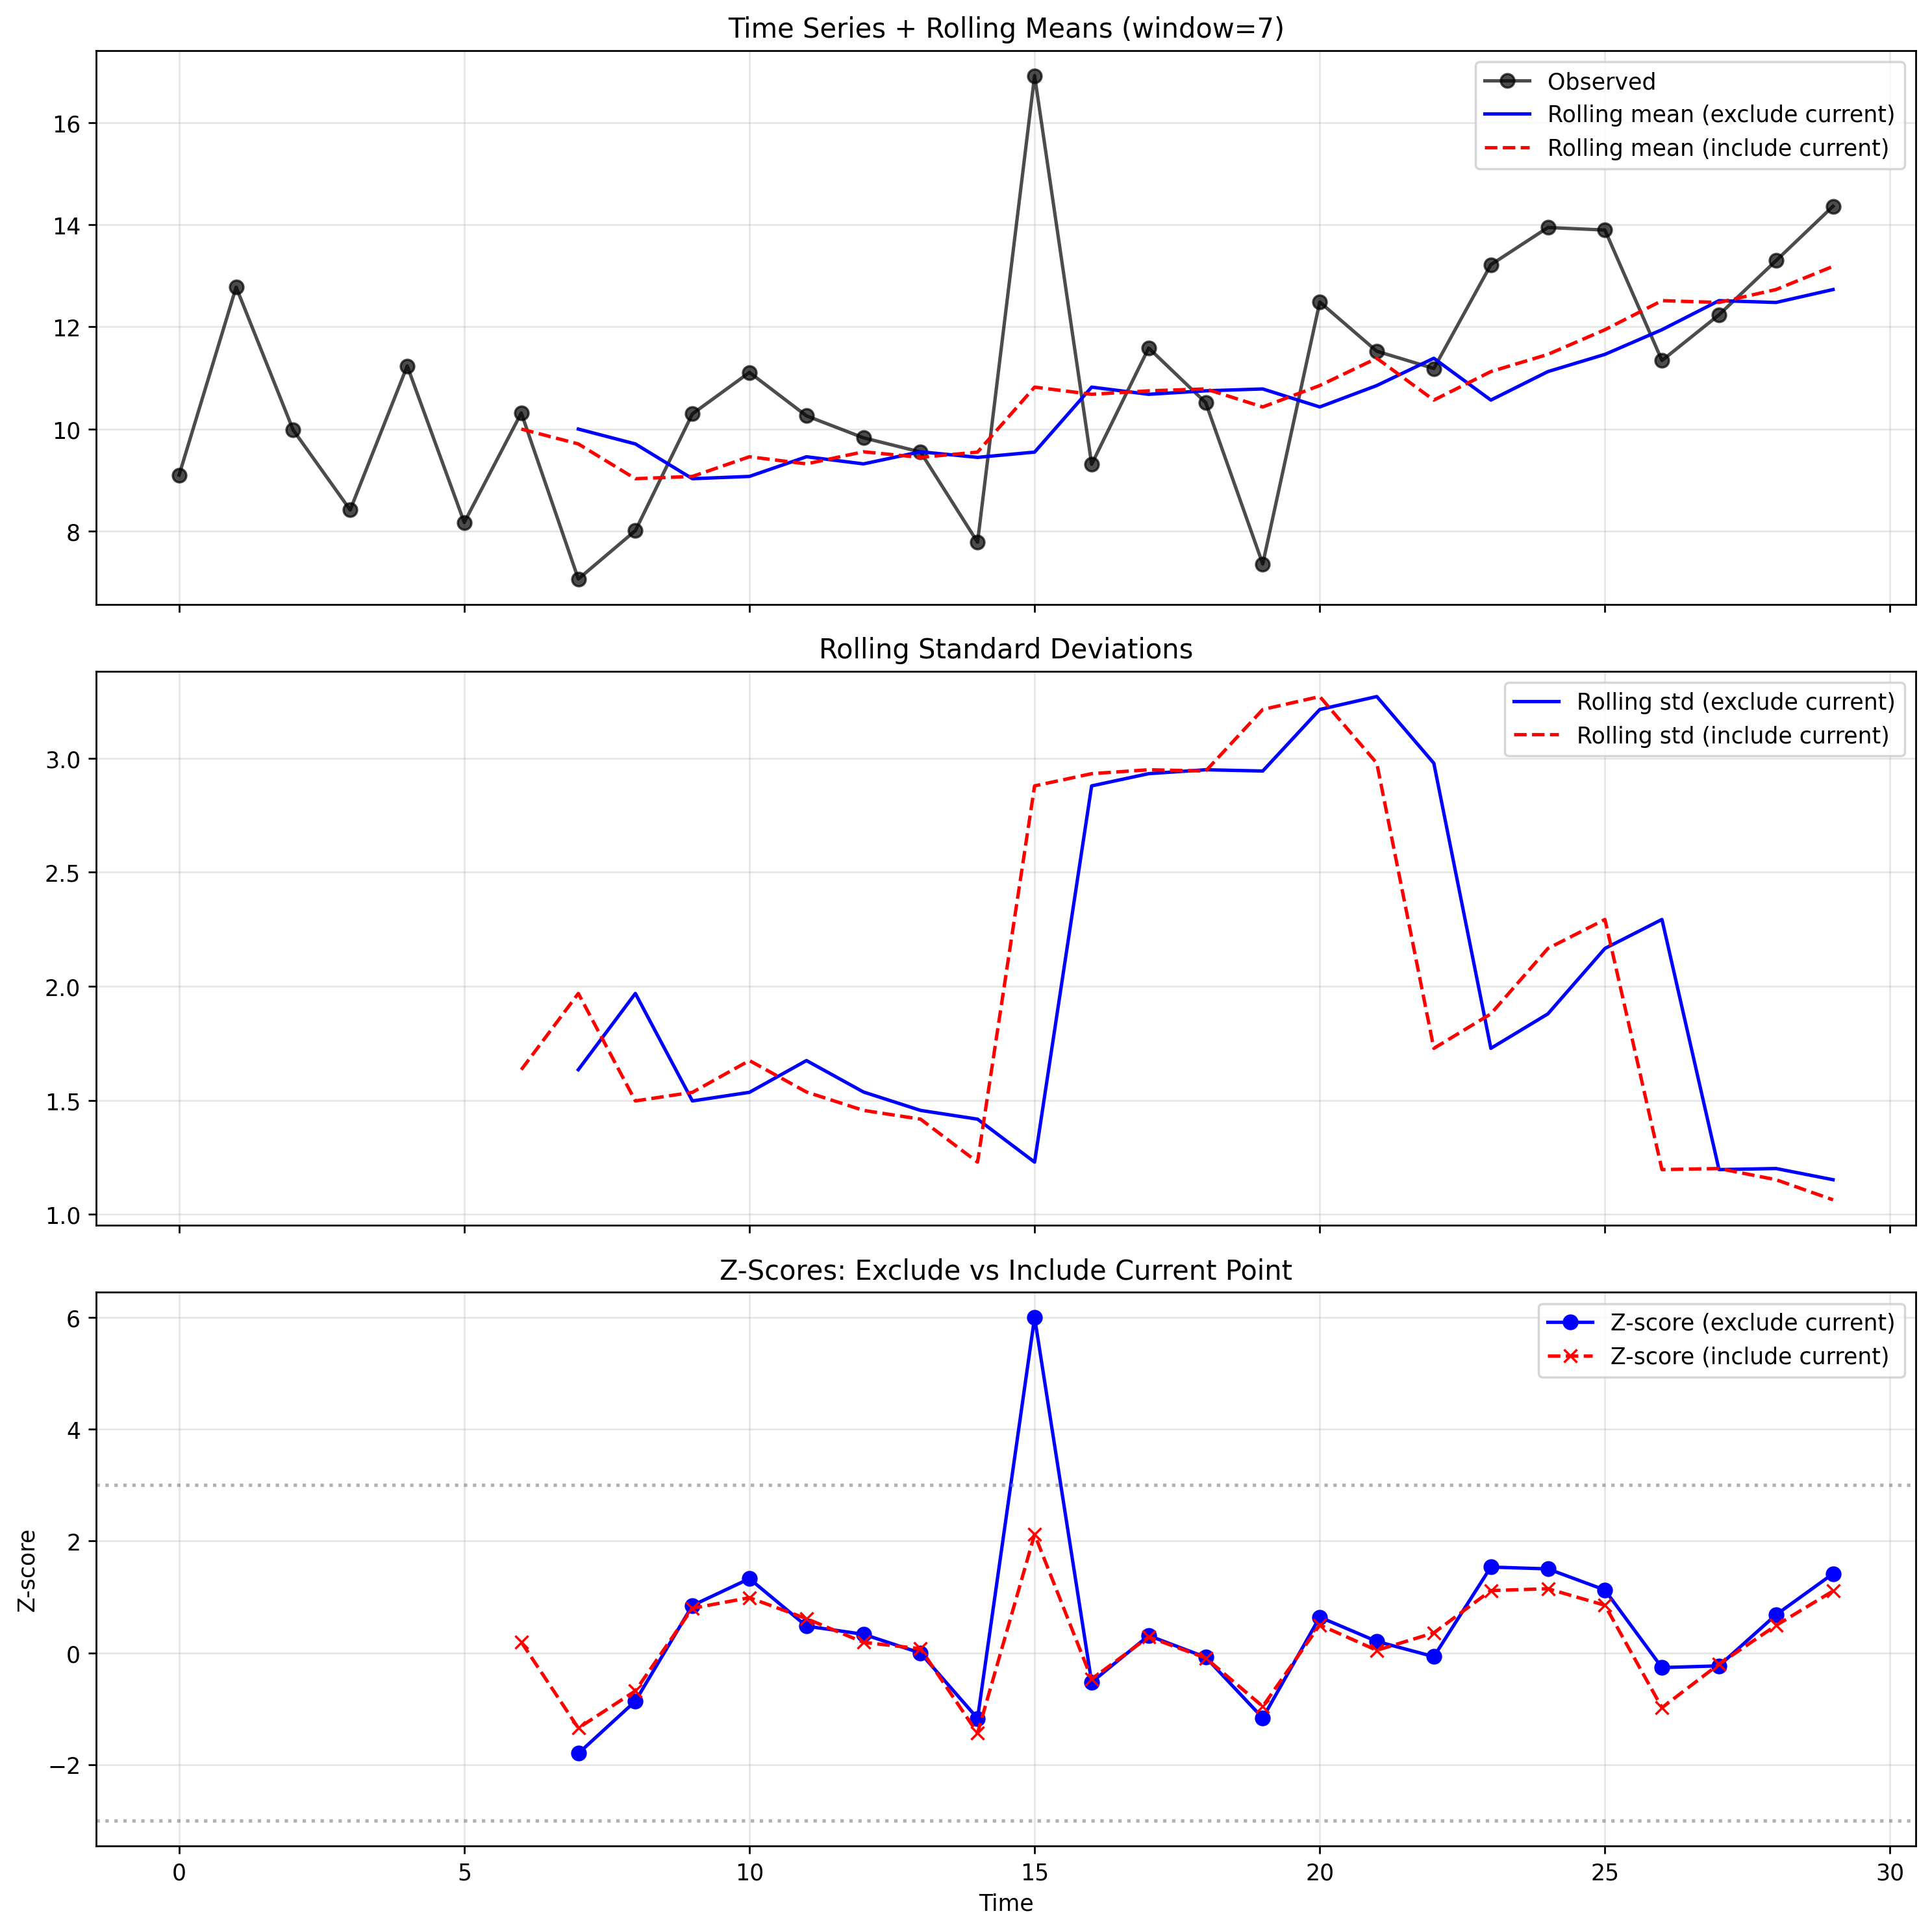

In [7]:
# Generate 30-point series: base level 10, slight upward trend in last 10 points, noise, one big outlier
n = 30
t = np.arange(n)
base = 10 + 0.1 * t[-10:]  # small trend only in last part
data = np.full(n, 10.0)
data[:20] = 10 + np.random.normal(0, 1.5, 20)
data[20:] = base + np.random.normal(0, 1.5, 10)
data[15] += 8  # big outlier at index 15

df = pd.DataFrame({'value': data}, index=t)

# Rolling window size
window = 7

# Version 1: EXCLUDE current point (recommended for detection)
df['roll_mean_ex'] = df['value'].shift(1).rolling(window).mean()
df['roll_std_ex']  = df['value'].shift(1).rolling(window).std()
df['z_ex'] = (df['value'] - df['roll_mean_ex']) / df['roll_std_ex']

# Version 2: INCLUDE current point (self-dampening)
df['roll_mean_inc'] = df['value'].rolling(window).mean()
df['roll_std_inc']  = df['value'].rolling(window).std()
df['z_inc'] = (df['value'] - df['roll_mean_inc']) / df['roll_std_inc']

# Add the Z-scores comparison as a third subplot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Top plot: original + means
ax1.plot(df.index, df['value'], 'o-', label='Observed', color='black', alpha=0.7)
ax1.plot(df.index, df['roll_mean_ex'], label='Rolling mean (exclude current)', color='blue')
ax1.plot(df.index, df['roll_mean_inc'], '--', label='Rolling mean (include current)', color='red')
ax1.set_title('Time Series + Rolling Means (window=7)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Middle plot: rolling stds
ax2.plot(df.index, df['roll_std_ex'], label='Rolling std (exclude current)', color='blue')
ax2.plot(df.index, df['roll_std_inc'], '--', label='Rolling std (include current)', color='red')
ax2.set_title('Rolling Standard Deviations')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Bottom plot: Z-scores comparison
ax3.plot(df.index, df['z_ex'], 'o-', label='Z-score (exclude current)', color='blue')
ax3.plot(df.index, df['z_inc'], 'x--', label='Z-score (include current)', color='red')
ax3.axhline(3, color='gray', linestyle=':', alpha=0.6)
ax3.axhline(-3, color='gray', linestyle=':', alpha=0.6)
ax3.set_title('Z-Scores: Exclude vs Include Current Point')
ax3.set_xlabel('Time')
ax3.set_ylabel('Z-score')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comparing t-stat and the Naive z-stat on trends

Correct t-statistic (using proper SE of slope):
  Slope: 0.2439
  SE of slope: 0.1412
  t-stat: 1.7276
  p-value (t-dist): 0.114756

Naive 'z-statistic' (using std(y)/sqrt(n) — incorrect):
  Slope: 0.2439
  Wrong SE: 0.5070
  z-stat: 0.4811


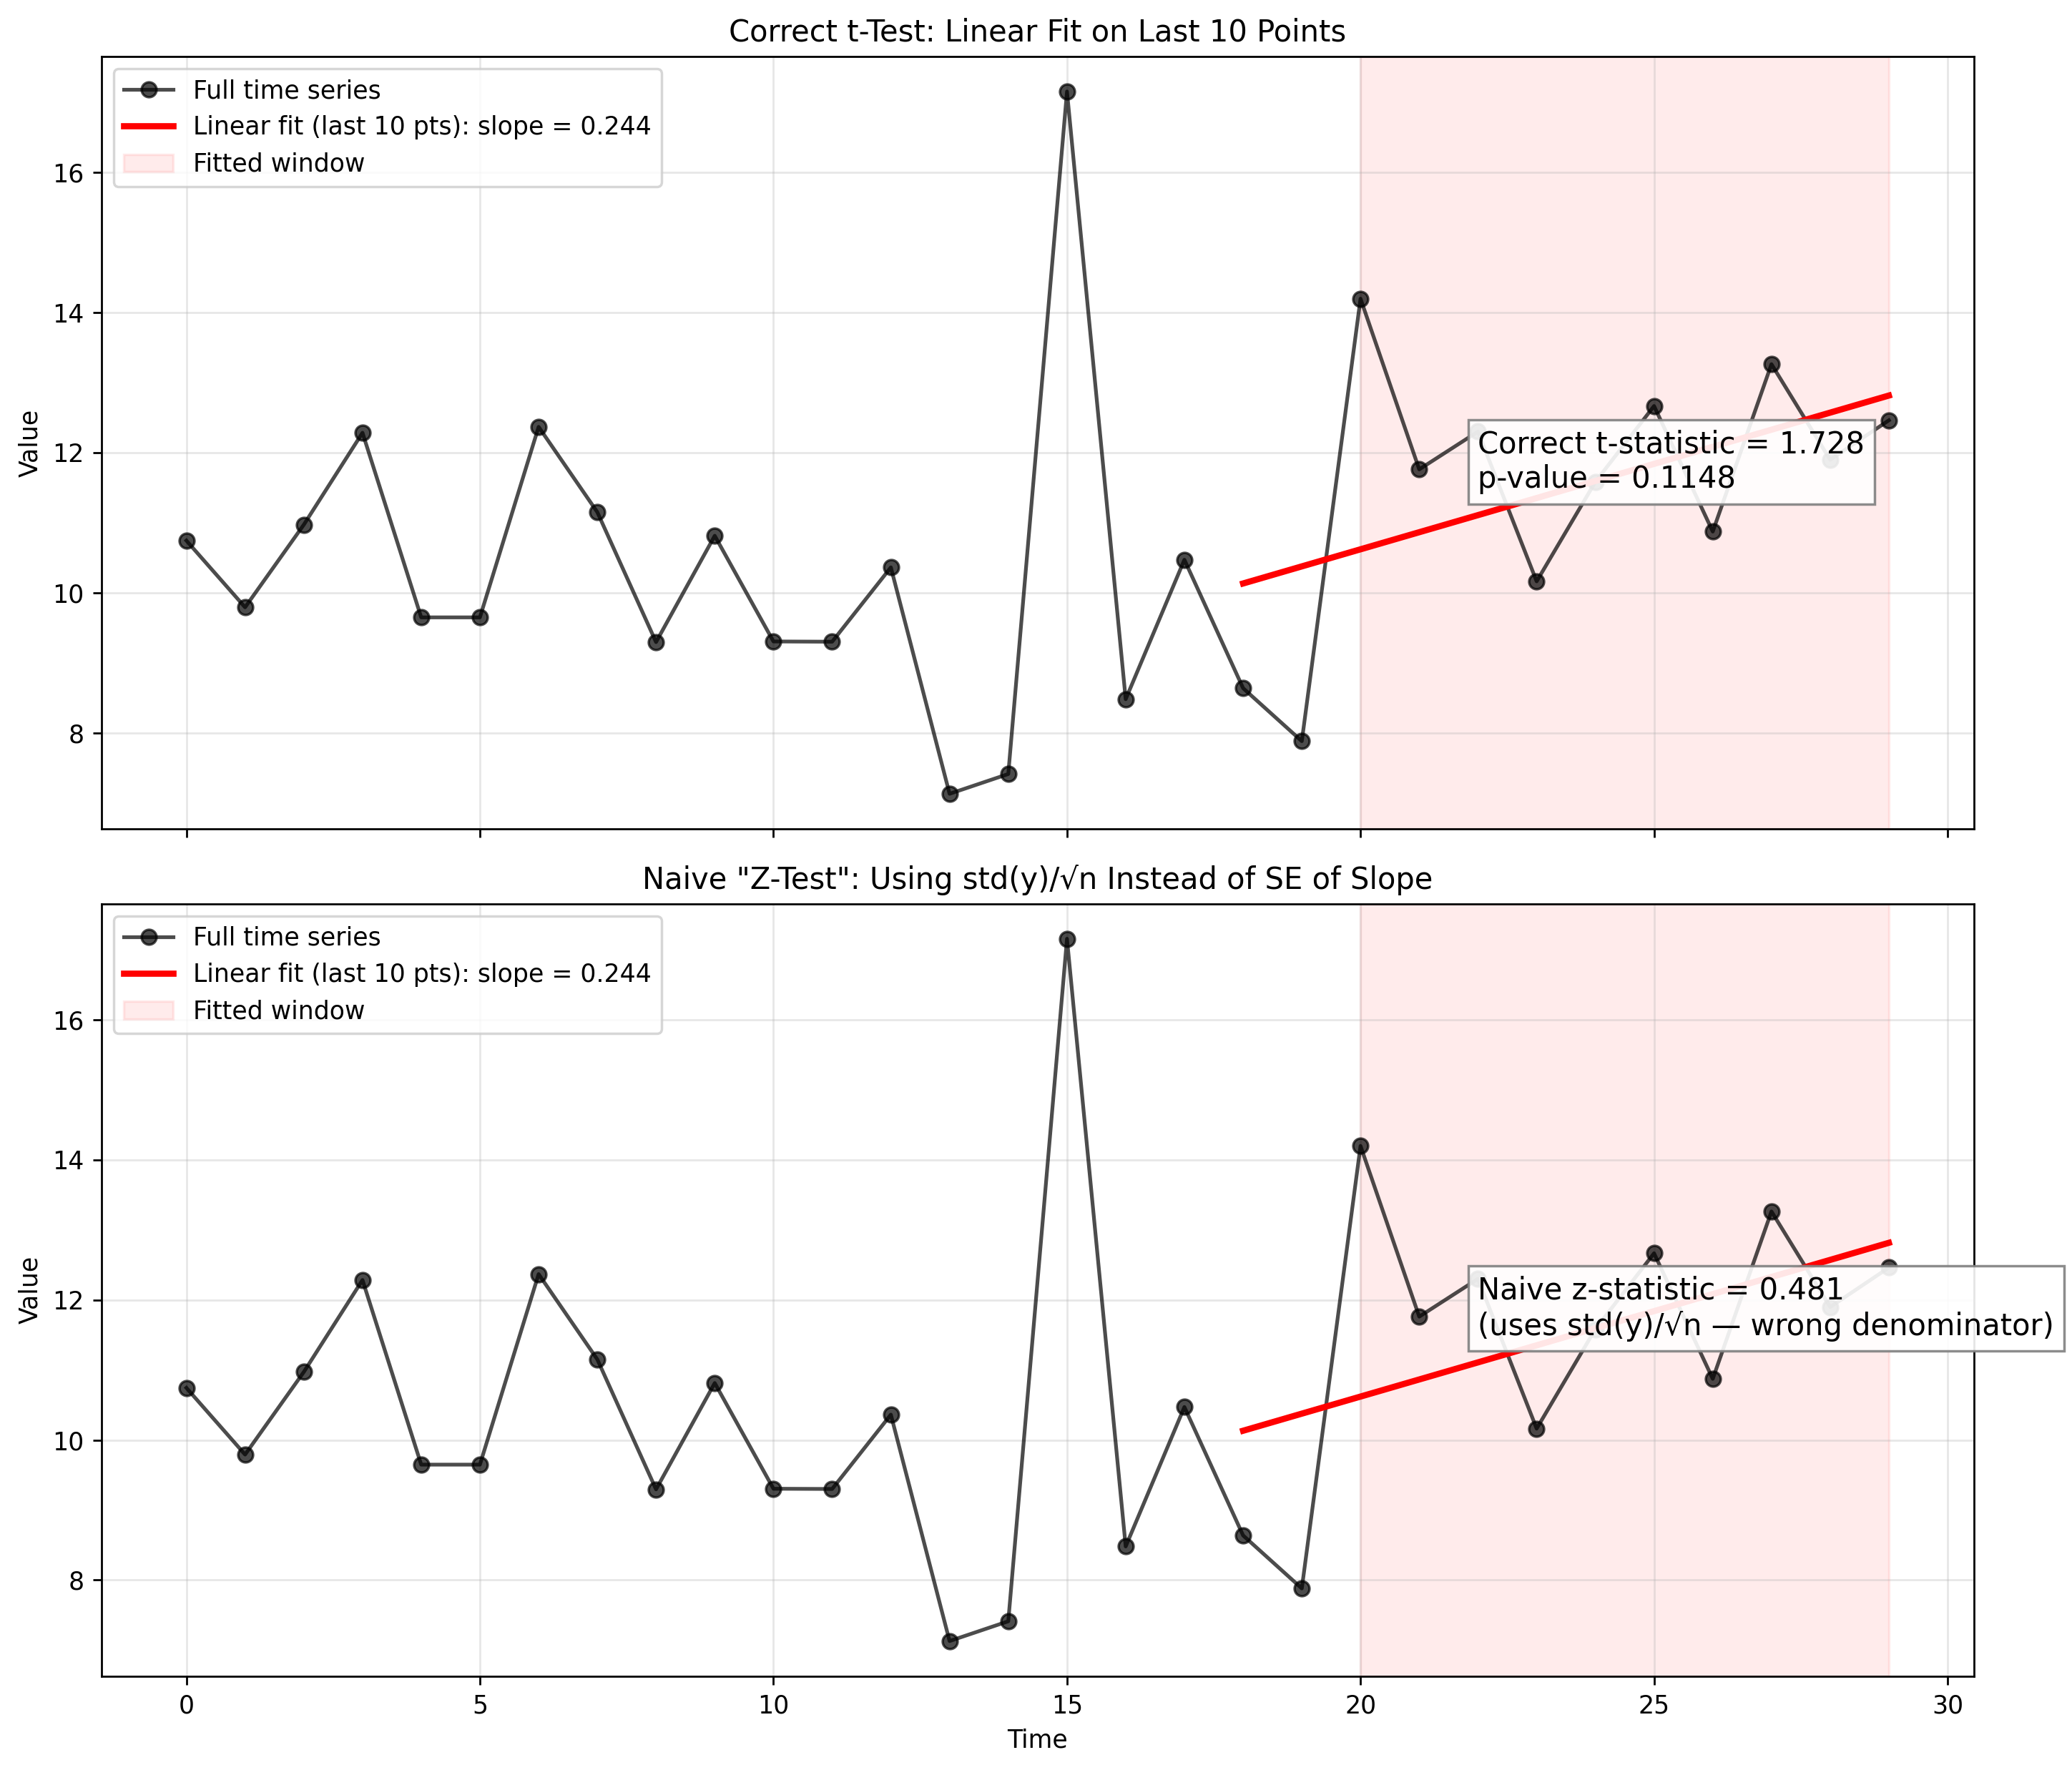

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ────────────────────────────────────────────────
# Data generation (same as before)
np.random.seed(42)
n = 30
t = np.arange(n)
data = np.full(n, 10.0)
data[:20] = 10 + np.random.normal(0, 1.5, 20)
data[20:] = 10 + 0.1 * t[20:] + np.random.normal(0, 1.5, 10)
data[15] += 8  # outlier at index 15

df = pd.DataFrame({'time': t, 'value': data})

# ────────────────────────────────────────────────
# Fit regression on last 10 points only (indices 20 to 29)
last10 = df.iloc[18:].copy()
slope, intercept, r_value, p_value, std_err = stats.linregress(
    last10['time'], last10['value']
)
last10['fitted'] = intercept + slope * last10['time']
t_stat = slope / std_err

# Naive "z-statistic" — using std(y) / sqrt(n) as denominator (wrong for trend)
z_std_err = np.std(last10['value']) / np.sqrt(len(last10))
z_stat = slope / z_std_err

# Print comparison
print("Correct t-statistic (using proper SE of slope):")
print(f"  Slope: {slope:.4f}")
print(f"  SE of slope: {std_err:.4f}")
print(f"  t-stat: {t_stat:.4f}")
print(f"  p-value (t-dist): {p_value:.6f}\n")

print("Naive 'z-statistic' (using std(y)/sqrt(n) — incorrect):")
print(f"  Slope: {slope:.4f}")
print(f"  Wrong SE: {z_std_err:.4f}")
print(f"  z-stat: {z_stat:.4f}")

# ────────────────────────────────────────────────
# Plot with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top: Correct t-statistic plot
ax1.plot(df['time'], df['value'], 'o-', color='black', alpha=0.7, linewidth=1.5,
         label='Full time series')
ax1.plot(last10['time'], last10['fitted'], color='red', linewidth=2.5,
         label=f'Linear fit (last 10 pts): slope = {slope:.3f}')
ax1.axvspan(20, 29, color='red', alpha=0.08, label='Fitted window')

ax1.text(22, 11.5, f'Correct t-statistic = {t_stat:.3f}\np-value = {p_value:.4f}',
         fontsize=12, bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'))

ax1.set_title('Correct t-Test: Linear Fit on Last 10 Points')
ax1.set_ylabel('Value')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Bottom: Naive z-statistic plot (showing the mistake)
ax2.plot(df['time'], df['value'], 'o-', color='black', alpha=0.7, linewidth=1.5,
         label='Full time series')
ax2.plot(last10['time'], last10['fitted'], color='red', linewidth=2.5,
         label=f'Linear fit (last 10 pts): slope = {slope:.3f}')
ax2.axvspan(20, 29, color='red', alpha=0.08, label='Fitted window')

ax2.text(22, 11.5, f'Naive z-statistic = {z_stat:.3f}\n(uses std(y)/√n — wrong denominator)',
         fontsize=12, bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'))

ax2.set_title('Naive "Z-Test": Using std(y)/√n Instead of SE of Slope')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Sampling from distributions to demonstrate t-statistic and p-value behavior

100%|██████████| 10000/10000 [00:08<00:00, 1184.71it/s]


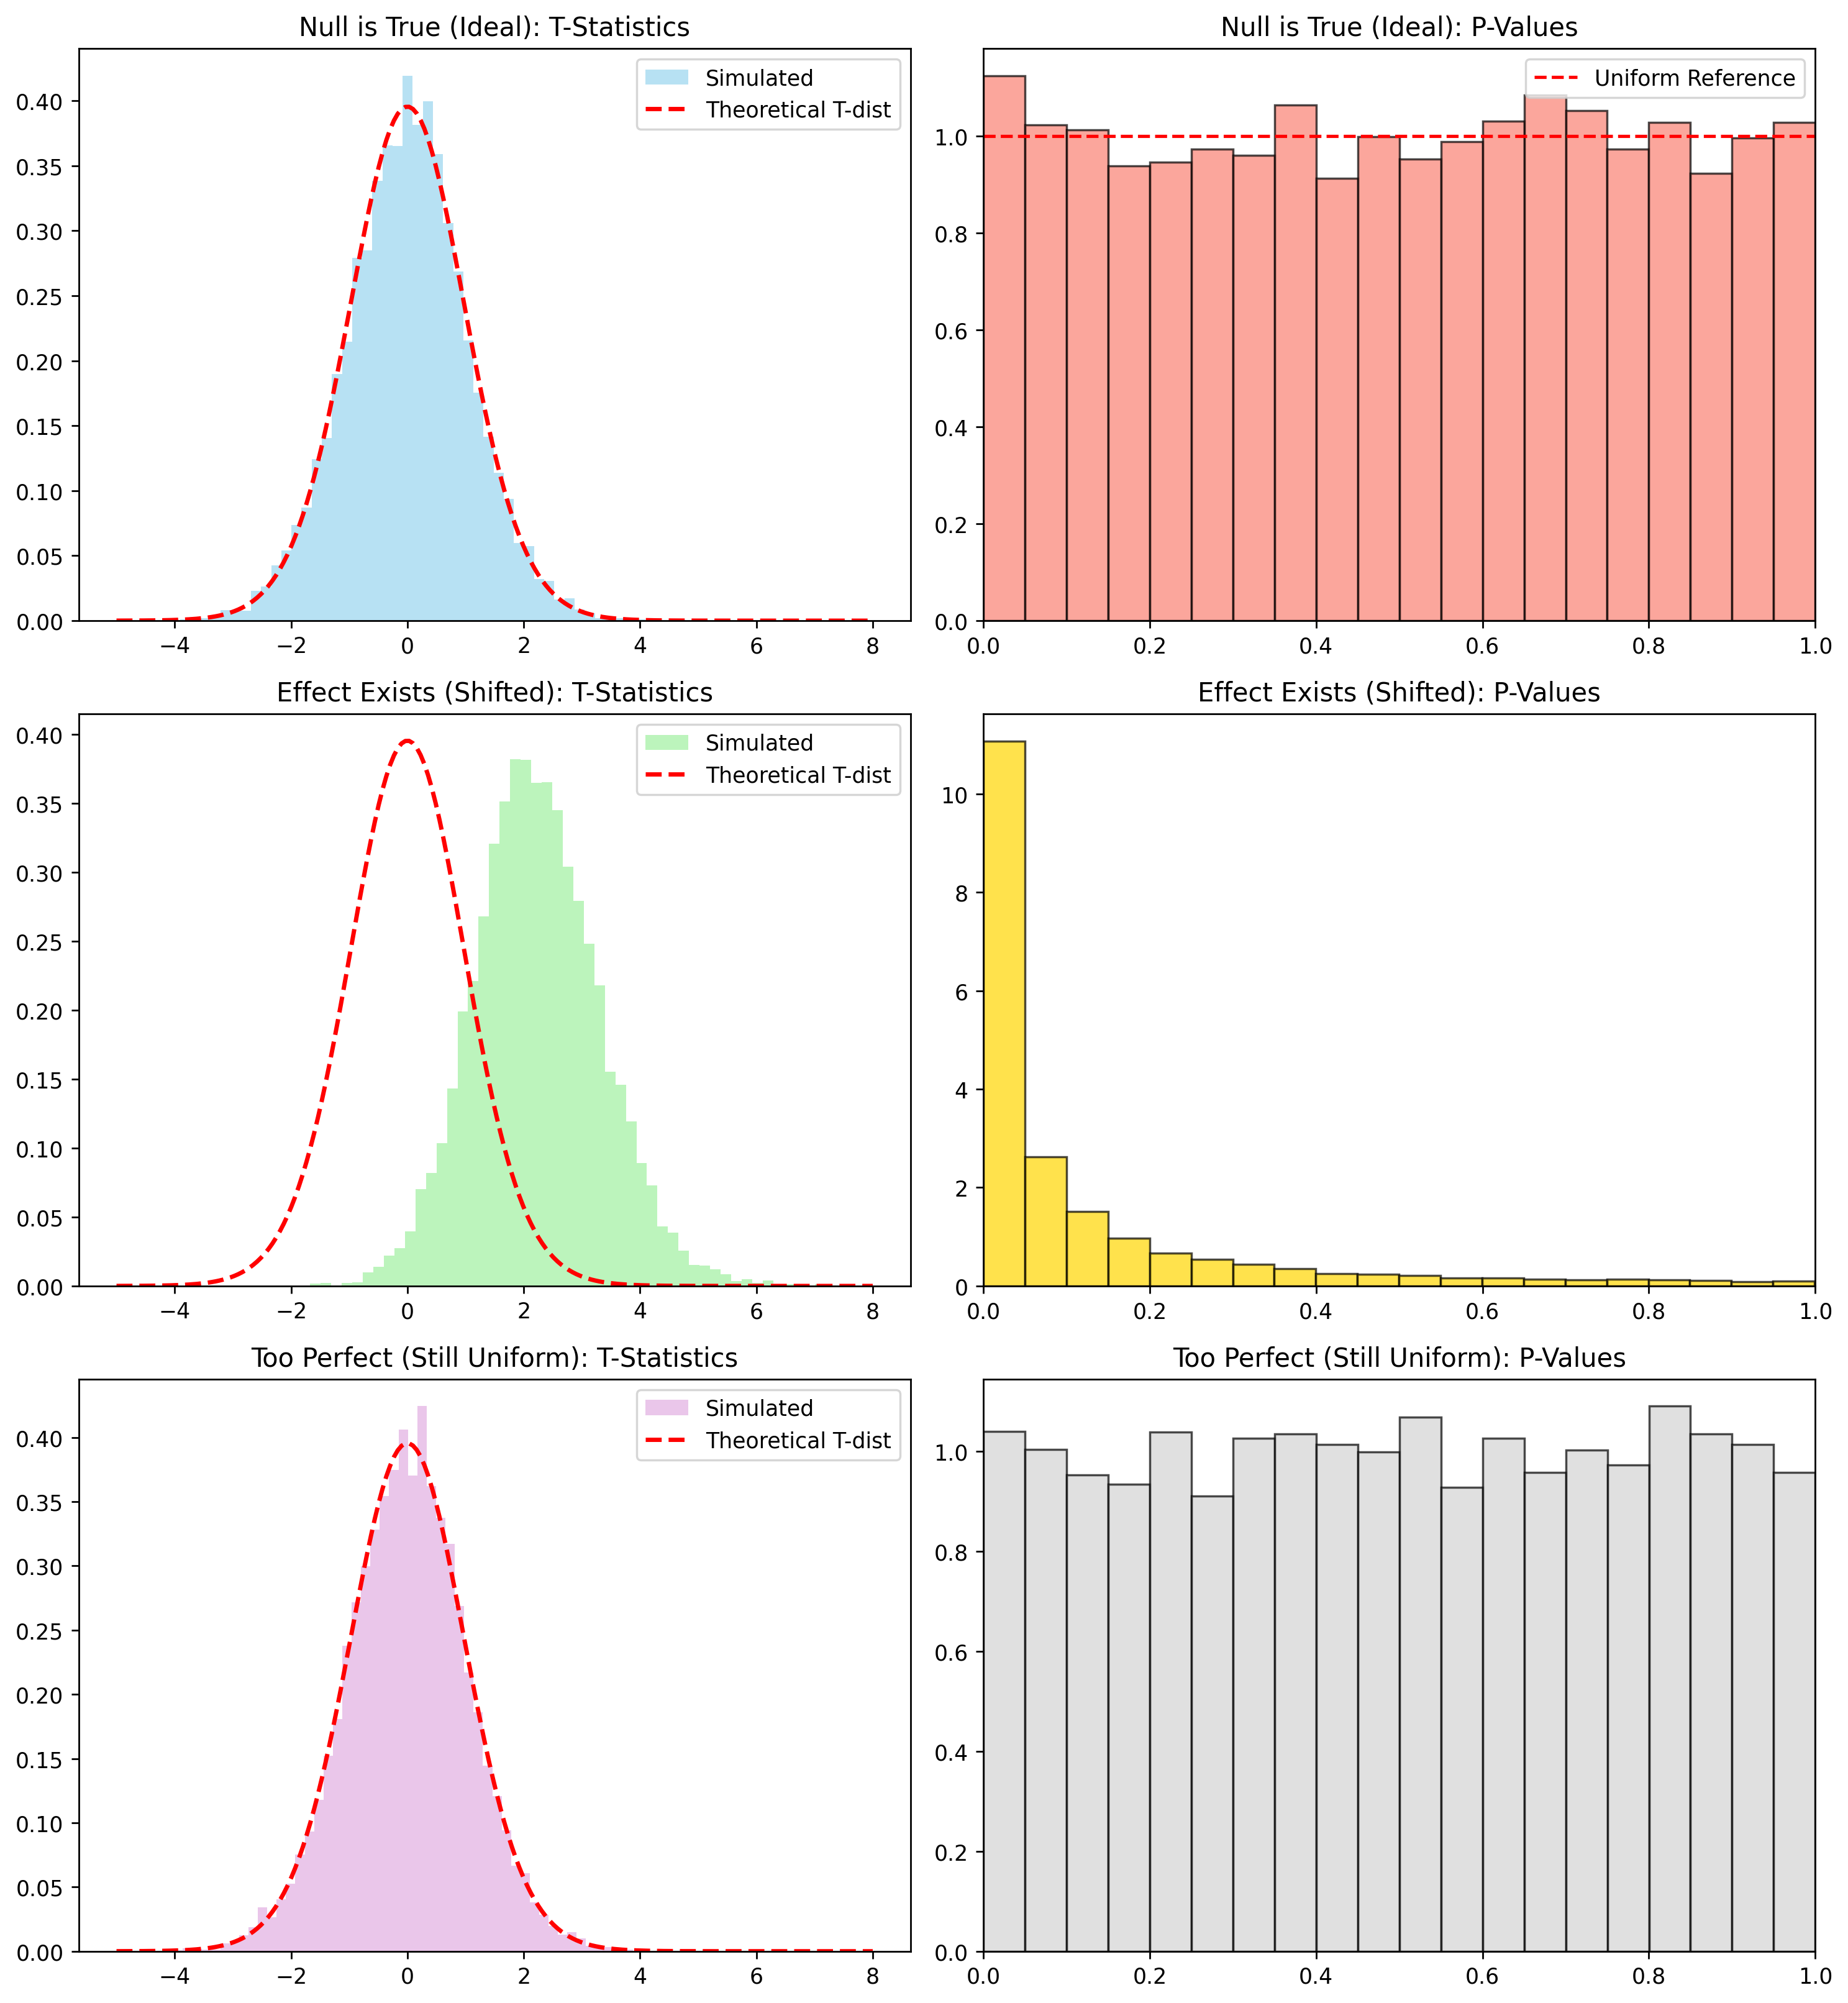

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import trange

n_simulations = 10_000
n_samples = 30
baseline_mu = 50
sigma = 10
df = n_samples - 1

def run_sim(true_mu, sigma_val):
    t_stats, p_vals = [], []
    for _ in trange(n_simulations):
        # Generate sample
        sample = np.random.normal(true_mu, sigma_val, n_samples)
        t, p = stats.ttest_1samp(sample, baseline_mu)
        t_stats.append(t)
        p_vals.append(p)
    return np.array(t_stats), np.array(p_vals)

# 1. Null is True (Ideal)
t_null, p_null = run_sim(baseline_mu, sigma)

# 2. Effect Exists (Shifted)
t_effect, p_effect = run_sim(baseline_mu + 4, sigma)

# 3. Too Perfect (Variance suppressed, Mean forced to baseline)
# We use a tiny sigma so the sample mean is always basically the baseline. Even then, we still get a uniform p-value distribution.
t_perfect, p_perfect = run_sim(baseline_mu, 0.1) 

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(12, 13))
x = np.linspace(-5, 8, 200)
t_pdf = stats.t.pdf(x, df)

scenarios = [
    (t_null, p_null, "Null is True (Ideal)", "skyblue", "salmon"),
    (t_effect, p_effect, "Effect Exists (Shifted)", "lightgreen", "gold"),
    (t_perfect, p_perfect, "Too Perfect (Still Uniform)", "plum", "lightgrey")
]

for i, (t_data, p_data, title, t_col, p_col) in enumerate(scenarios):
    # T-Stat Plots
    axes[i, 0].hist(t_data, bins=50, density=True, color=t_col, alpha=0.6, label="Simulated")
    axes[i, 0].plot(x, t_pdf, 'r--', lw=2, label="Theoretical T-dist")
    axes[i, 0].set_title(f"{title}: T-Statistics")
    axes[i, 0].legend()
    
    # P-Value Plots
    axes[i, 1].hist(p_data, bins=20, density=True, color=p_col, alpha=0.7, edgecolor='black')
    axes[i, 1].set_title(f"{title}: P-Values")
    axes[i, 1].set_xlim(0, 1)
    if i == 0:
        axes[i, 1].axhline(1, color='red', linestyle='--', label='Uniform Reference')
        axes[i, 1].legend()

plt.tight_layout()
plt.show()